In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from uproot_io import Events, View

In [2]:
# Interaction type lookup
import csv
interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
# print(interaction_dictionary)

In [3]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [135]:
def energy(event_number):
    """needs to return energy in last X% over total energy"""
    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]        
        
        # Discarding particles with no hits
        if x.size <= 5:
            continue
            
        else:
            
            # Get the last 30% of the energy data
            percent = int(0.8 * len(adc))
            X = adc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(adc)
            result = Xsum / total
            
            E = np.append(E, result)
            
            # Finding the particle type
            pdg = events.mc_pdg[i]
            particleType = np.append(particleType, pdg)   
            
            
    return E, particleType

In [136]:
energy(1)

(array([0.17324314, 0.22637343, 0.37725332, 0.18104754, 0.19615318,
        0.31042141, 0.18014486, 0.19180329, 0.12851559, 0.1660745 ,
        0.19207536, 0.207311  ]),
 array([  13., 2212., 2212., 2212., 2212., 2212.,    0.,    0.,   22.,
          22.,  211., 2212.]))

In [137]:
random_numbers = np.random.randint(0, max(events.event_number), 5000)

In [138]:
e = []
p = []
for i in random_numbers:
    e, p = np.append(e, energy(i)[0]), np.append(p, energy(i)[1])

In [139]:
inf = np.where(np.isinf(e))

# Create a boolean mask to keep or remove indices
keep_indices = np.ones(len(e), dtype=bool)
keep_indices[inf] = False

# Use boolean indexing to get the modified array
e = e[keep_indices]
p = p[keep_indices]

In [140]:
e.shape, p.shape

((40196,), (40196,))

In [141]:
df = pd.DataFrame({"energy": e, "particle": p})

In [142]:
# Using 0 to indicate tracks, 1 to indicate showers.

mapping = {
    11: 1,
    -11: 1,
    22: 1
}

df["class"] = df["particle"].map(mapping).fillna(0)

In [143]:
tracksQuery = df['class'] == 0.0
showersQuery = df['class'] == 1.0

ftracks = df[tracksQuery]
fshowers = df[showersQuery]

tracks = ftracks['energy'].values
showers = fshowers['energy'].values

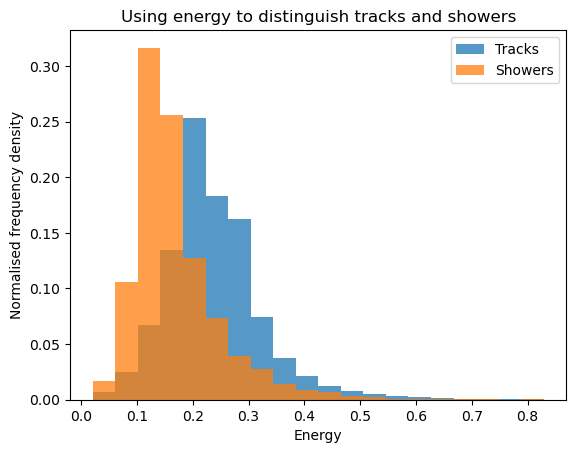

In [144]:
n_bins = 20
hist2, bin_edges = np.histogram(showers, bins=n_bins)
hist1, _ = np.histogram(tracks, bins=bin_edges)

bin_widths = np.diff(bin_edges)
    
hist1_normalized = hist1 / len(tracks)
hist2_normalized = hist2 / len(showers)

plt.bar(bin_edges[:-1], hist1_normalized, width=bin_widths, align='edge', alpha=0.75, label='Tracks')
plt.bar(bin_edges[:-1], hist2_normalized, width=bin_widths, align='edge', alpha=0.75, label='Showers')
plt.title("Using energy to distinguish tracks and showers")
plt.ylabel("Normalised frequency density")
plt.xlabel("Energy")

plt.legend()
plt.show()